# Сборный проект

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируются ли продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Откройте файл с данными и изучите общую информацию

In [3]:
import pandas as pd
import matplotlib.pyplot as mpl
from scipy import stats as st
import os
from pathlib import Path

In [4]:
ROOT_DIR = Path(os.path.abspath("__file__")).parent.parent

In [5]:
data = pd.read_csv(ROOT_DIR / 'datasets/games.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Подготовьте данные

### Заменить названия столбцов (привести к нижнему регистру)

In [8]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование данных в нужные типы и обработка пропусков

In [9]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Строки с неизвестным годом выпуска игры удалим, остальные приведем к типу int:

In [10]:
data = data.dropna(subset=['year_of_release'])

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int')

"Оценки критиков" приведем к типу int и заполним пропуски.

Такое количество пропусков (8'578) может быть результатом технологической ошибки. Заполним пропуски нулями:

In [12]:
data['critic_score'] = data['critic_score'].fillna(0)

In [13]:
data['critic_score'] = data['critic_score'].astype('int')

Из сети Интернет можно узнать, что рейтинг "tbd" (To Be Determined) означает, что его еще не определили.

Для последующей корректной работы с данными столбца "Оценка пользователей" изменим тип с object на float и заполним пропуски и "tbd" нулями:

In [14]:
data['user_score'] = data['user_score'].fillna(0)

In [15]:
data['user_score'] = data['user_score'].replace('tbd', 0)

In [16]:
data['user_score'] = data['user_score'].astype('float')

Проверим столбец Жанр на пропуски:

In [17]:
data[data['genre'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,0,0.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,0,0.0,NaN


У обеих игр отсутствуют данные с названием, жанром и оценками. Удалим две строки:

In [18]:
data = data.drop(index=[659, 14244])

In [19]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Узнаём, что 'RP'(Rating Pending) - рейтинга еще нет, а 'K-A' до 1998 года был известен как 'от детей до взрослых', что сейчас равнозначно рейтигу 'E' (для всех). Источник: https://ru.wikibrief.org/wiki/Entertainment_Software_Rating_Board

Строкам с отстуствующим значениям присвоим рейтинг 'RP', а 'K-A' переименуем в 'E' для последующего корректного анализа:

In [20]:
data['rating'] = data['rating'].fillna('RP')

In [21]:
data['rating'] = data['rating'].replace('K-A', 'E')

### Посчитаем суммарные продажи во всех регионах (миллионы проданных копий) и запишем их в отдельный столбец:

In [22]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,RP,31.38


## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы:

In [23]:
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

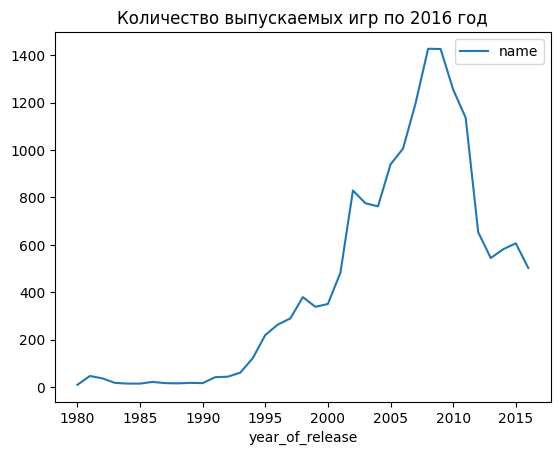

In [24]:
data.groupby('year_of_release').agg({'name':'count'}).plot()
mpl.title("Количество выпускаемых игр по 2016 год")
mpl.show()

**Видим сильный прирост в количетсве выпускаемых игр в 2001 году. Будем считать, что с этого года данные более важны.**

### Kак менялись продажи по платформам:

In [25]:
data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False).head(10)

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


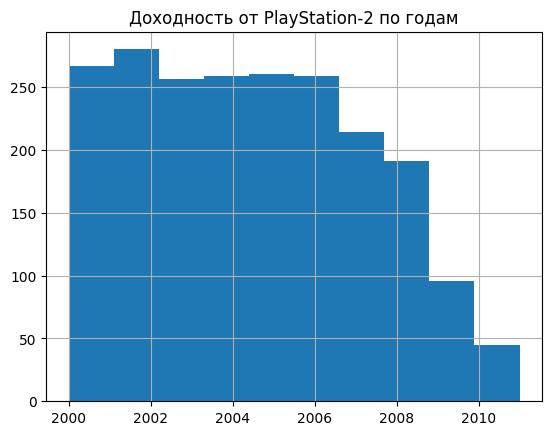

In [26]:
data[data['platform'] == 'PS2']['year_of_release'].hist()
mpl.title("Доходность от PlayStation-2 по годам")
mpl.show()

**PS2** была популярна более 6-и лет

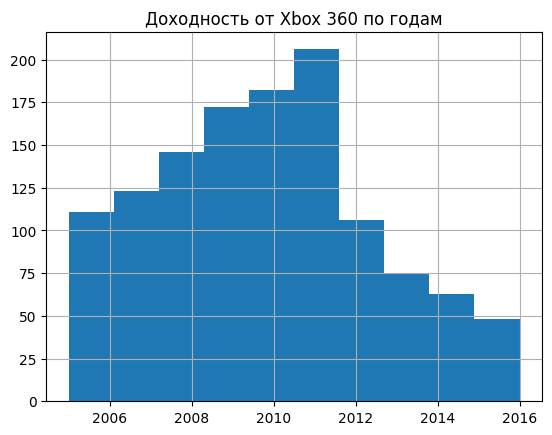

In [27]:
data[data['platform'] == 'X360']['year_of_release'].hist()
mpl.title("Доходность от Xbox 360 по годам")
mpl.show()

**X360** с 2005 года уверенно наращивала популярность до резкого спада в 2012 году

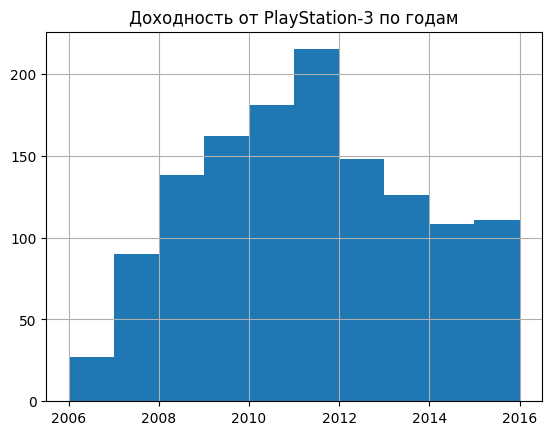

In [28]:
data[data['platform'] == 'PS3']['year_of_release'].hist()
mpl.title("Доходность от PlayStation-3 по годам")
mpl.show()

**PS3** при быстром подъёме была популярной недолго - с 2009 года по 2012

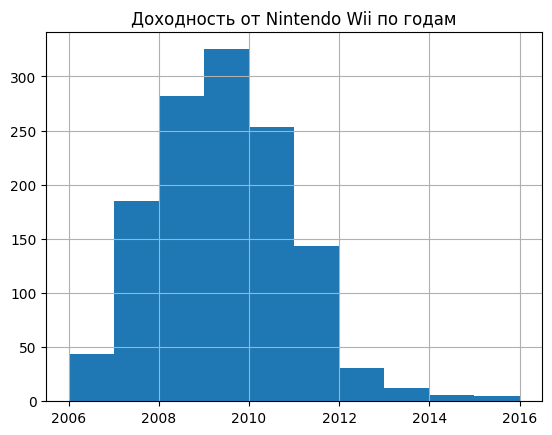

In [29]:
data[data['platform'] == 'Wii']['year_of_release'].hist()
mpl.title("Доходность от Nintendo Wii по годам")
mpl.show()

**Wii** с 2007 по 2011 года держала хорошие позиции

__Каждый год появляются новые платформы, при этом характерный срок их исчезновения по графикам видим через +/- 10 лет.__

### Актуальный период

Из графиков видим, что спрос на игры снижается с 2012 года. 

Для анализа будем считать данные актуальными за 2 года (с 2014 года)  и исследовать их.

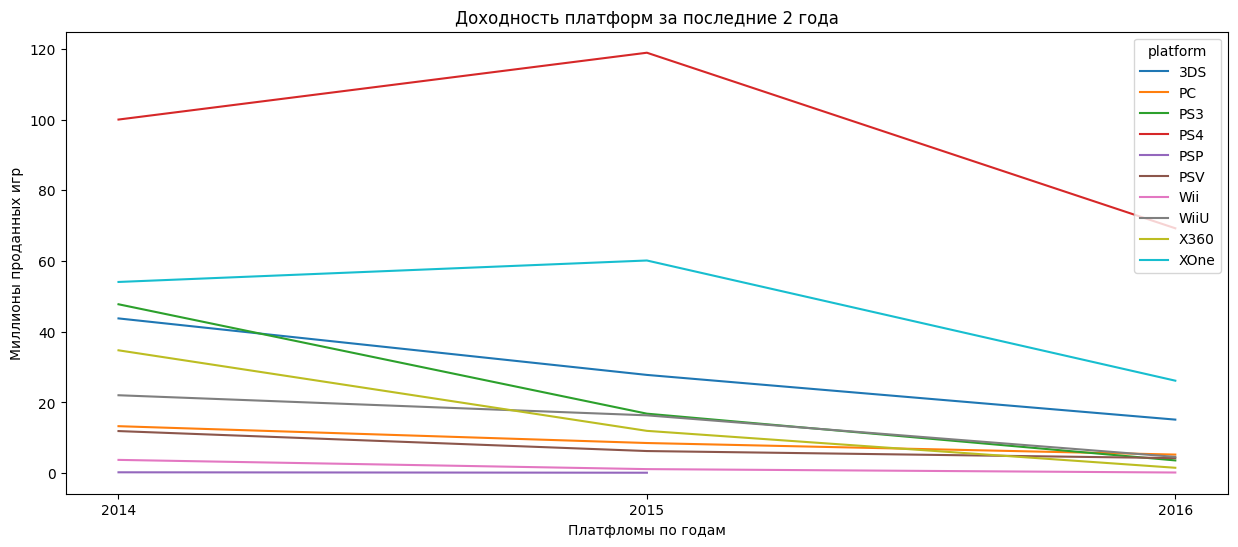

In [30]:
data.query('year_of_release >= 2014').sort_values(by='all_sales', ascending=False).pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum').plot(figsize=(15, 6))
mpl.xlabel('Платфломы по годам')
mpl.ylabel('Миллионы проданных игр')
mpl.title("Доходность платформ за последние 2 года")
mpl.xticks([2014, 2015, 2016])
mpl.show()

Несмотря на снижение количества продаваемых игр на всех платформах с 2015 года, **потенциально прибыльными будем считать PS4, XOne и 3DS**

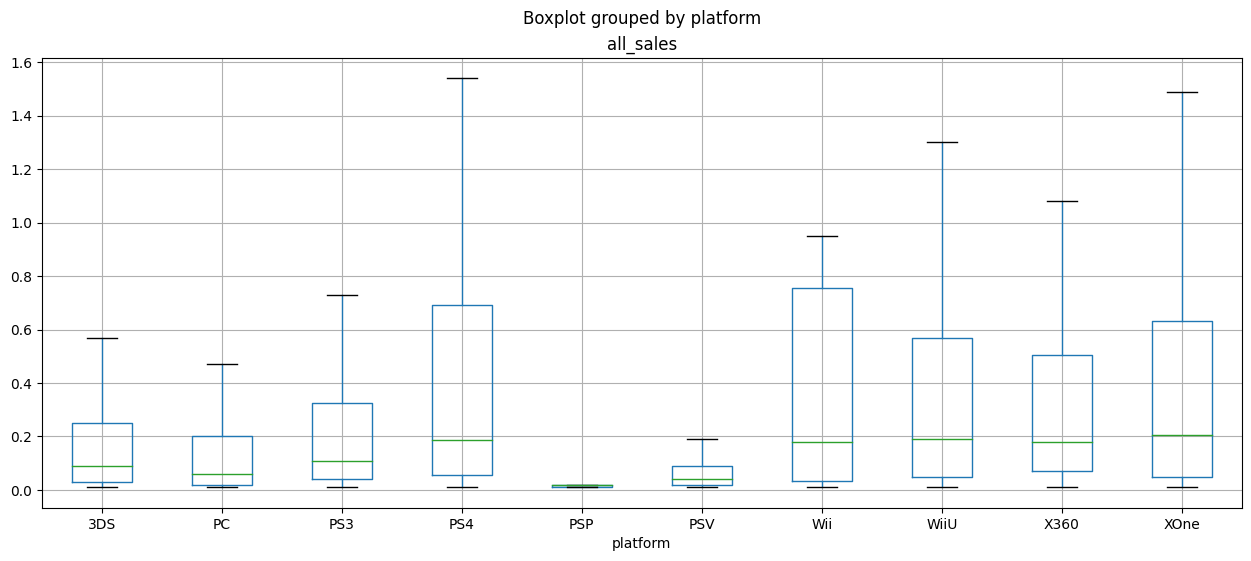

In [31]:
data.query('year_of_release >= 2014').boxplot(column='all_sales', by='platform', figsize=(15, 6), showfliers=False)
mpl.show()

Наличие выбросов может говорить о большой популярности каких-то отдельных  игр.

### Для подсчета корреляции возьмём платформу с наибольшиими продажами - PS4

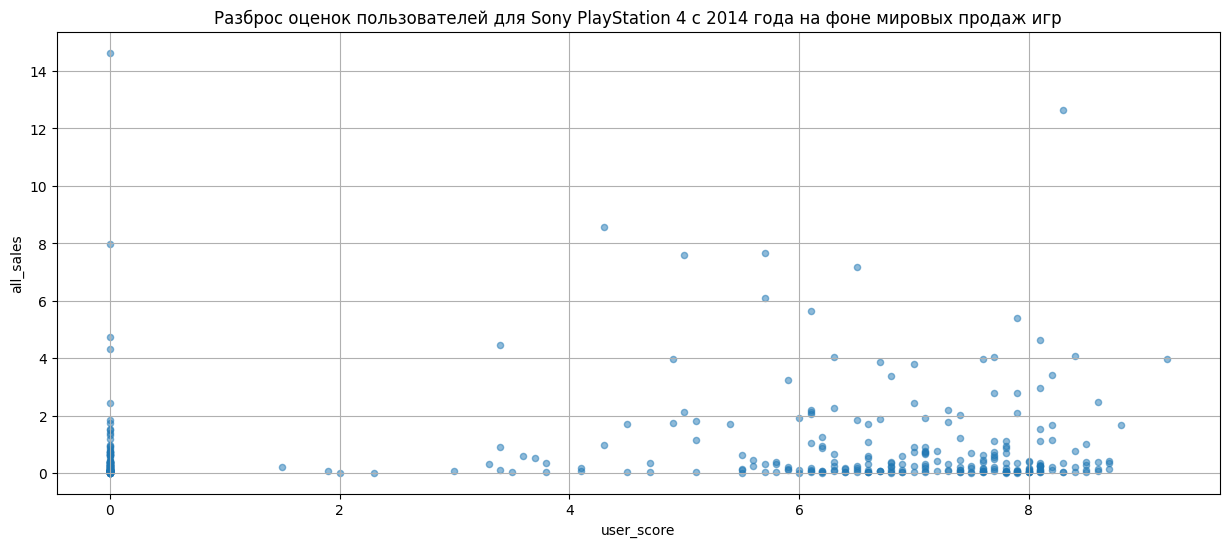

In [32]:
data.query('platform == "PS4" and year_of_release >= 2014').plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(15, 6), grid=True)
mpl.title("Разброс оценок пользователей для Sony PlayStation 4 с 2014 года на фоне мировых продаж игр")
mpl.show()

In [33]:
data.query('platform == "PS4" and user_score > 0 and year_of_release >= 2014')['user_score'].corr(data['all_sales'])

-0.040131589472697356

**Корреляция отрицательная, но близкая к нулю. Можно предположить, что низкие оценки либо не так часто влияли на покупки игр, либо пользователи оставляют отзывы через некоторое время - бо́льшие продажи происходят с релизом**

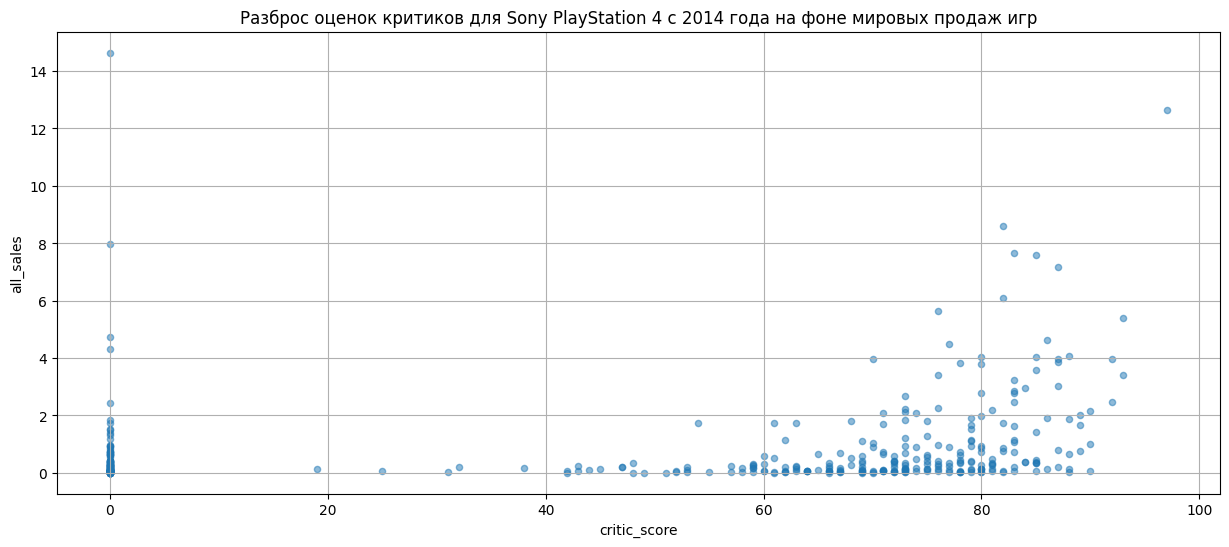

In [34]:
data.query('platform == "PS4"').plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(15, 6), grid=True)
mpl.title("Разброс оценок критиков для Sony PlayStation 4 с 2014 года на фоне мировых продаж игр")
mpl.show()

In [35]:
data.query('platform == "PS4" and critic_score > 0 and year_of_release >= 2014')['critic_score'].corr(data['all_sales'])

0.40266141068104083

**Корреляция положительная - скорее всего геймеры прислушиваются к оценкам критиков**.

Посмотрим данные по оставшимся платформам:

In [36]:
data.query('platform != "PS4" and user_score > 0 and year_of_release >= 2014')['user_score'].corr(data['all_sales'])

-0.02347818723797556

In [37]:
data.query('platform != "PS4" and critic_score > 0 and year_of_release >= 2014')['critic_score'].corr(data['all_sales'])

0.3094740026001152

Такая же ситуация.

### Распределение игр по жанрам.

In [38]:
data.query('year_of_release >= 2014').groupby('genre').agg({'all_sales':'sum', 'name':'count'})

,all_sales,name
genre,,
Action,199.36,619
Adventure,17.55,185
Fighting,28.22,60
Misc,37.55,113
Platform,18.09,38
Puzzle,2.21,14
Racing,27.52,69
Role-Playing,101.44,221
Shooter,170.94,128


Видим, что в разы больше игр продалось в жанре Экшен.

Также **Экшен лидирует по мировым продажам** - 199.36 млн игр. За ним следует жанр Шутер, замыкает тройку лидеров жанр Спортивных игр.

**Меньше всего приносят Головоломки** - 2.21 млн игр за актуальные годы (2014-2016).

In [39]:
data.query('year_of_release >= 2014').groupby('genre').agg({'all_sales':'mean', 'name':'count'}).sort_values(by='all_sales', ascending=False)

,all_sales,name
genre,,
Shooter,1.335469,128
Sports,0.680000,161
Platform,0.476053,38
Fighting,0.470333,60
Role-Playing,0.459005,221
Racing,0.398841,69
Misc,0.332301,113
Action,0.322068,619
Simulation,0.298409,44


По средним показателям мировых продаж чаще купили игры в жанре Шутер, далее следуют Спортивные игры.

**Меньше всего покупают Приключенческие игры** - 0.095 млн игр за актуальные годы (2014-2016).

## Портрет пользователя каждого региона

### Пользователи из Северной Америки:

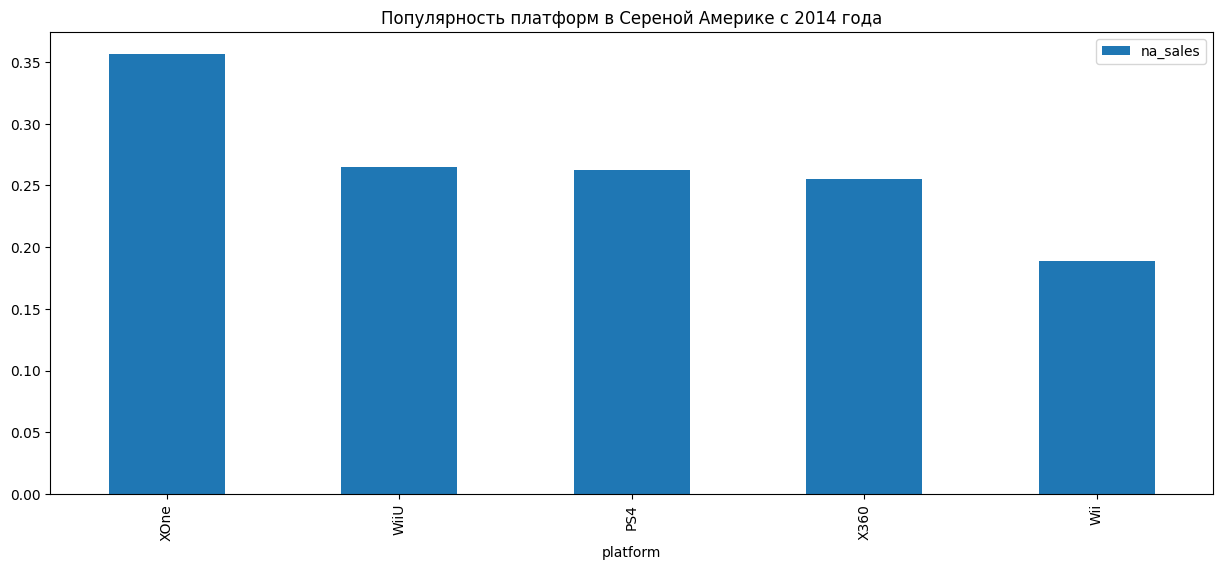

In [40]:
data.query('year_of_release >= 2014').pivot_table(index='platform', values='na_sales').sort_values(by='na_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Популярность платформ в Сереной Америке с 2014 года")
mpl.show()

**ТОП-5 платформ Северной Америки**: XOne, WiiU, PS4, X360 и Wii.

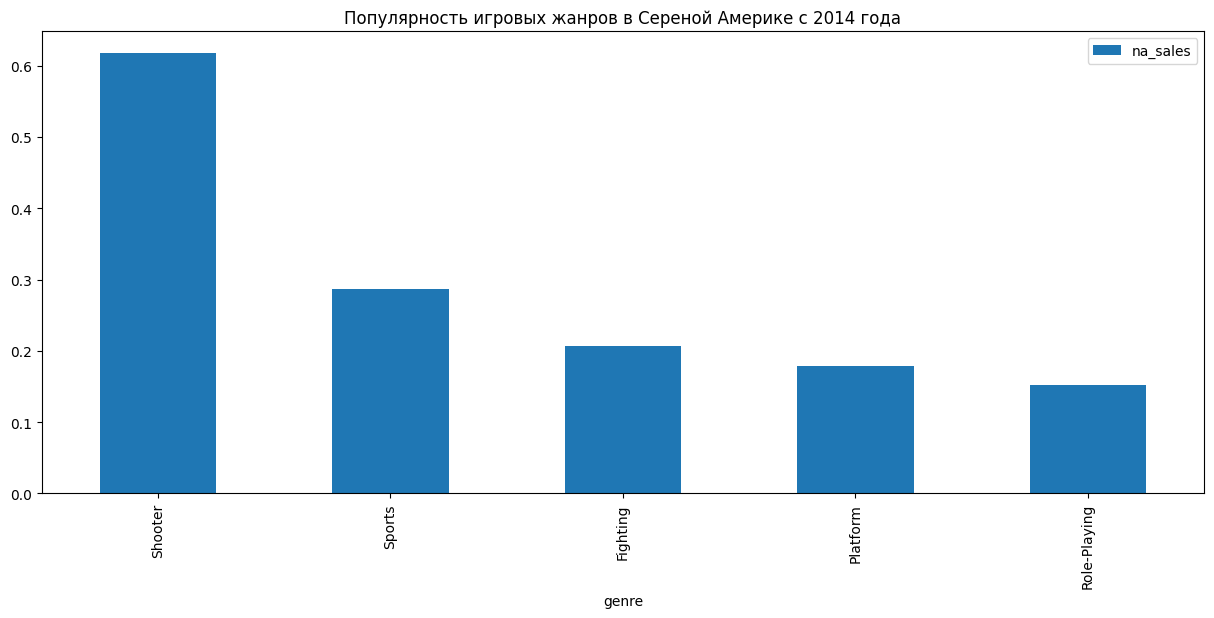

In [41]:
data.query('year_of_release >= 2014').pivot_table(index='genre', values='na_sales').sort_values(by='na_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Популярность игровых жанров в Сереной Америке с 2014 года")
mpl.show()

**ТОП-5 игровых жанров Северной Америки**: Shooter, Sports, Fighting, Platform и Role-Playing.

Шутер более чем в 2 раза прибыльнее чем Спортс и Файтинг, которым в свою очередь уступают Платформеры и Ролевые игры.

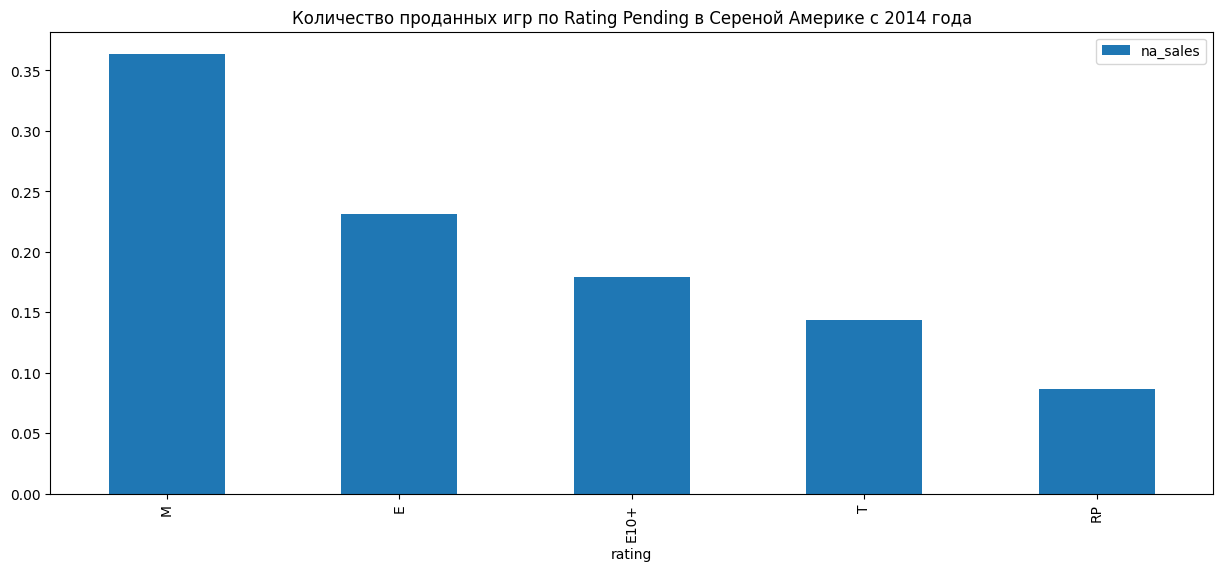

In [42]:
data.query('year_of_release >= 2014').pivot_table(index='rating', values='na_sales').sort_values(by='na_sales', ascending=False).plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр по Rating Pending в Сереной Америке с 2014 года")
mpl.show()

Конечно, больше игр приобретается без возрастного ценза (Е) и для лиц страше 17 лет (М). Также нужно отметить, что свой небольшой вклад делает группа игр с отсутствием рейтинга (RP).

### Пользователи из Европы:

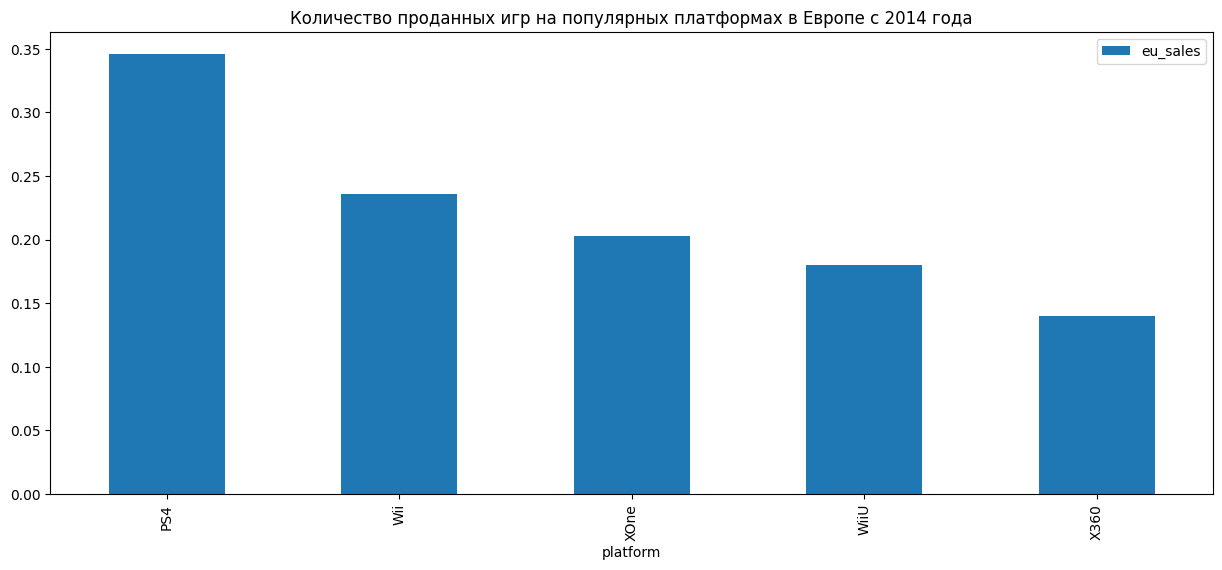

In [43]:
data.query('year_of_release >= 2014').pivot_table(index='platform', values='eu_sales').sort_values(by='eu_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр на популярных платформах в Европе с 2014 года")
mpl.show()

**ТОП-5 платформ Европы**: PS4, Wii, XOne, WiiU и X360.

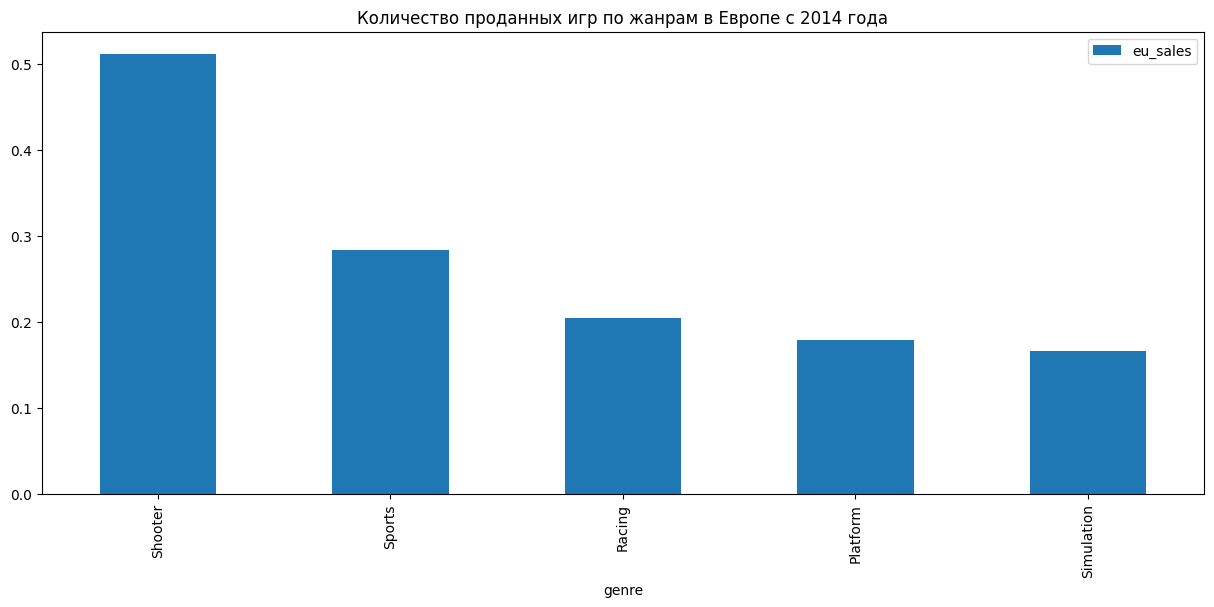

In [44]:
data.query('year_of_release >= 2014').pivot_table(index='genre', values='eu_sales').sort_values(by='eu_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр по жанрам в Европе с 2014 года")
mpl.show()

**ТОП-5 игровых жанров Европы**: Shooter, Sports, Racing, Platform и Simulation.

Шутер почти в 2 раза прибыльнее чем Спортс. Рейсинг, Платформеры и Симуляторы имеют небольшой разрыв.

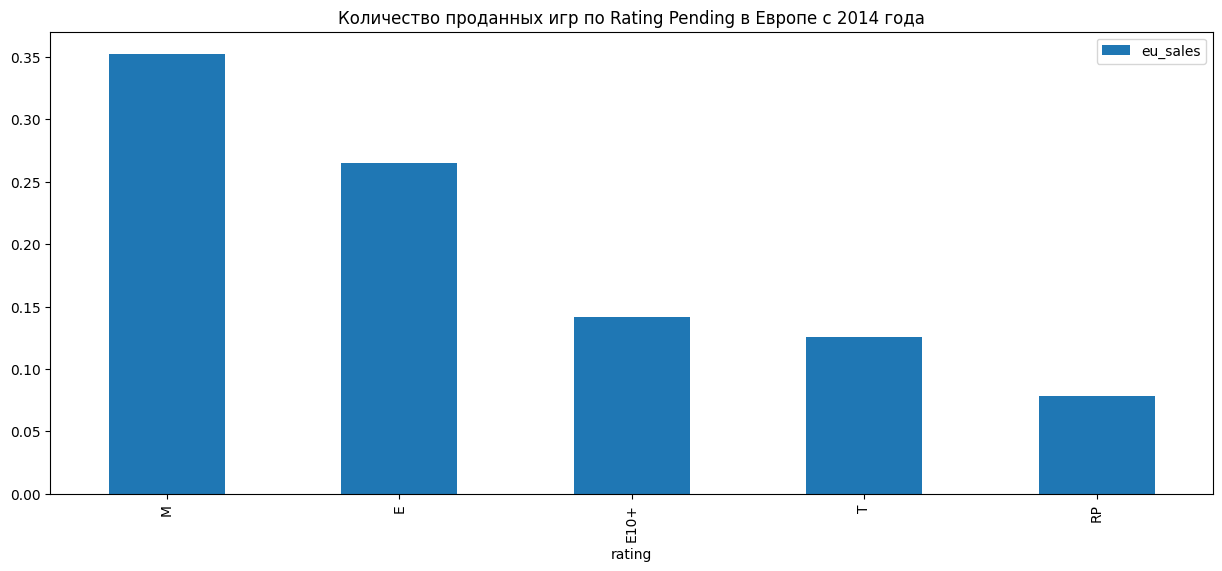

In [45]:
data.query('year_of_release >= 2014').pivot_table(index='rating', values='eu_sales').sort_values(by='eu_sales', ascending=False).plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр по Rating Pending в Европе с 2014 года")
mpl.show()

Как и в Северной Америке: больше игр приобретается без возрастного ценза (Е) и для лиц страше 17 лет (М). Также нужно отметить, что свой небольшой вклад делает группа игр с отсутствием рейтинга (RP).

### Пользователи из Японии:

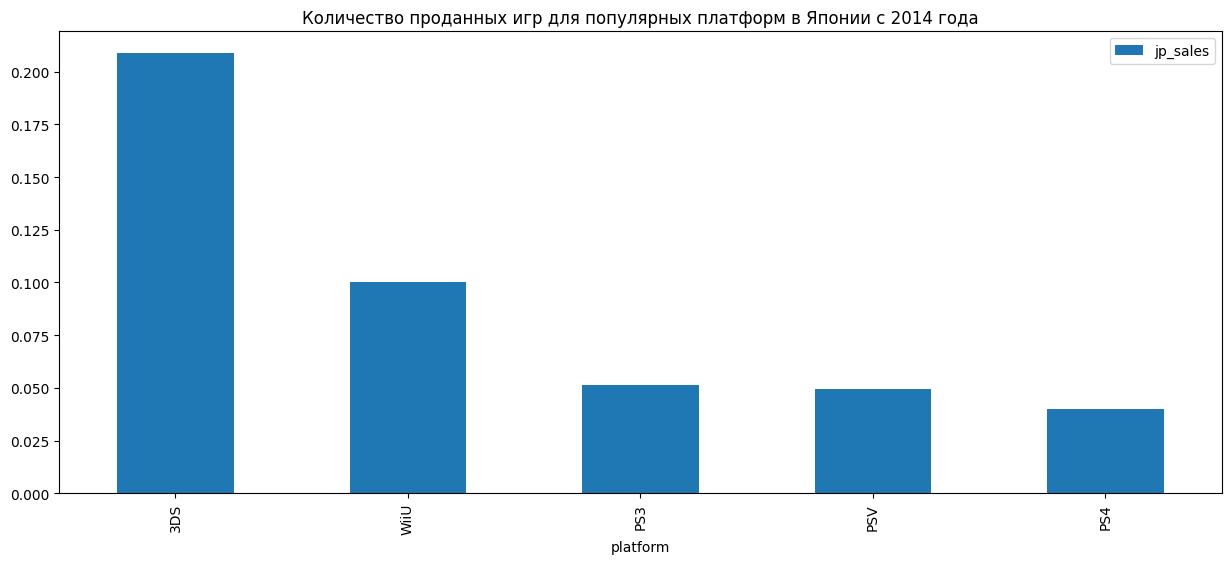

In [46]:
data.query('year_of_release >= 2014').pivot_table(index='platform', values='jp_sales').sort_values(by='jp_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр для популярных платформ в Японии с 2014 года")
mpl.show()

**ТОП-5 платформ Японии**: 3DS, WiiU, PS3, PSV и PS4.

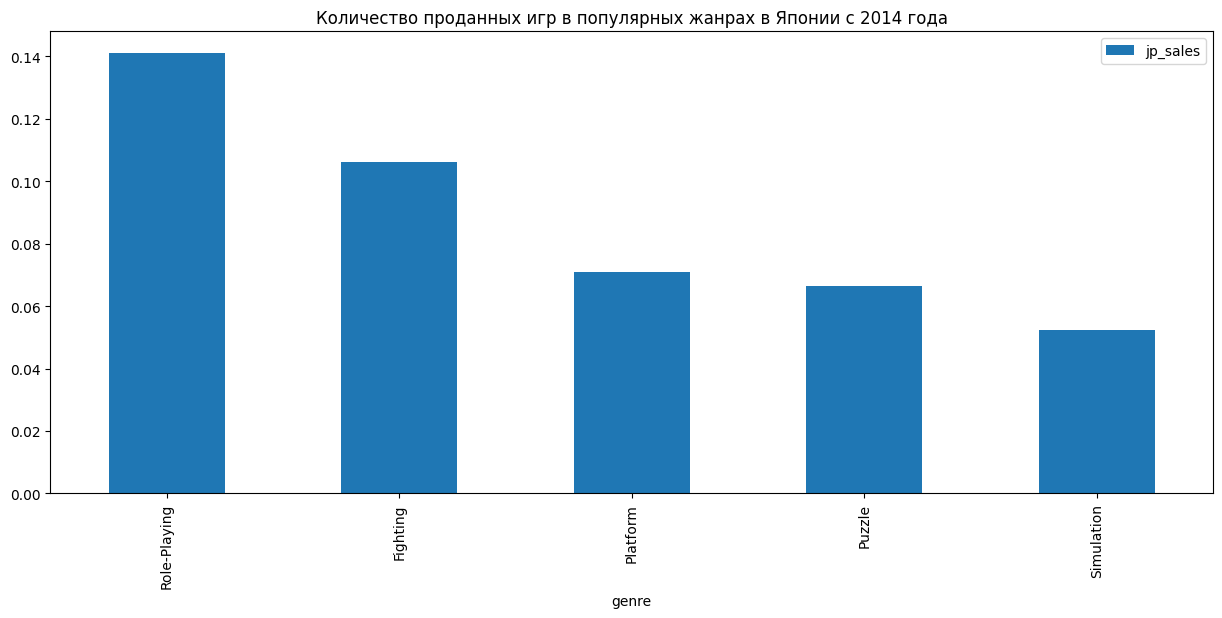

In [47]:
data.query('year_of_release >= 2014').pivot_table(index='genre', values='jp_sales').sort_values(by='jp_sales', ascending=False).head().plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр в популярных жанрах в Японии с 2014 года")
mpl.show()

**ТОП-5 игровых жанров Японии**: Role-Playing, Fighting, Platform, Puzzle и Simulation.

Самый прибыльный жанр в Японии - Ролевые игры. Далее идёт Файтинг. Платформеры, Головоломки и Симуляторы примерно на одном уровне.

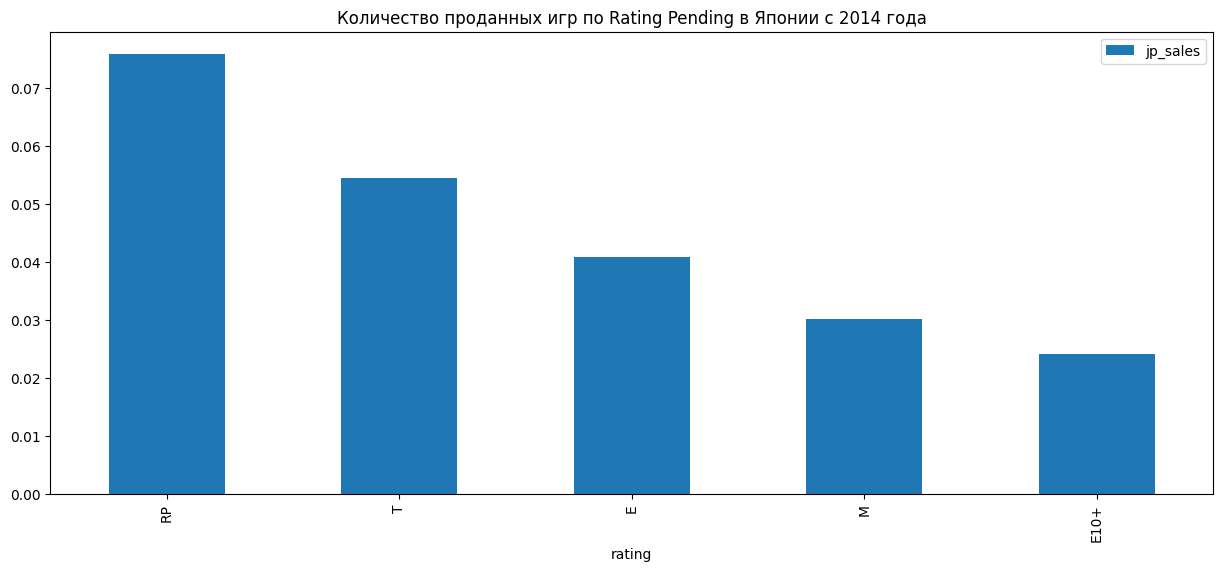

In [48]:
data.query('year_of_release >= 2014').pivot_table(index='rating', values='jp_sales').sort_values(by='jp_sales', ascending=False).plot(kind='bar', figsize=(15, 6))
mpl.title("Количество проданных игр по Rating Pending в Японии с 2014 года")
mpl.show()

Бо́льшая часть проданных игр не имела рейтинга (RP). В отличии от Северной Америки и Европы, в Японии много игр приобретается с цензом 13+

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?

**Н_0**: Средний пользовательский рейтинг **Xbox One =** Среднему пользовательскому рейтингу **PC**

**Н_1**: Средний пользовательский рейтинг **Xbox One не равен** Среднему пользовательскому рейтингу **PC**

In [49]:
data_xbox = data.query('platform == "XOne" and user_score > 0')['user_score']
data_pc = data.query('platform == "PC" and user_score > 0')['user_score']
alpha = .05
results = st.ttest_ind(data_xbox, data_pc, equal_var = False)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


**Средние пользовательские оценки этих платформ разные**.

### Средние пользовательские рейтинги жанров Action и Sports  разные?

**Н_0**: Средний пользовательский рейтинг **Action** равен Среднему пользовательскому рейтингу **Sports**

**Н_1**: Средний пользовательский рейтинг **Action не** равен Среднему пользовательскому рейтингу **Sports**

In [50]:
data_action = data.query('genre == "Action" and user_score > 0')['user_score']
data_sports = data.query('genre == "Sports" and user_score > 0')['user_score']
alpha = .01
results = st.ttest_ind(data_action, data_sports, equal_var = False)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


In [51]:
print(data_sports.mean(), data_action.mean())
print(data_sports.median(), data_action.median())

6.951433857539316 7.058129175946549
7.4 7.4


По среднему значению есть разница в 0,1 по оценкам пользователей игр жанров Action и Sports, по медиане же рейтинг одинаков. 

**_Будем придерживаться нулевой гипотезы и считать, что рейтинги этих жанров равны._**

## Общий вывод:

1) При подготовке данных были заменён регистр названий столбцов, типы некоторых столбцов приведены к корректным, удалены либо обработаны пропуски. Также был создан столбцев по общемировому доходу с игр.

2) При анализе данных выявлен рост количетсва выпускаемых игр с 2001 года. По имеющимся данным за все годы самой доходной платформой была PS2, а за актуальный для нас период (с 2014 года) - PS4.

3) При этом самая популярная платформа Северной Америки - это XOne, Eвропы - PS4, а Японии - 3DS. В Северной Америке и Европе чаще покупают игры жанра Шутер, а в Японии - Ролевые.

_В 2017 году нам нужно сделать ставку на игры в жанре Шутер для платформы PlayStation 4._